#Implementing Locality Sensitive Hashing from scratch

In [1]:
import pandas as pd
import numpy as np                                             # dense matrices                                                 # see below for install instruction
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

In [2]:
wiki = pd.read_csv('/Users/April/Downloads/people_wiki.csv')

##Extract TF-IDF vectors

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [4]:
corpus = load_sparse_csr('/Users/April/Downloads/people_wiki_tf_idf.npz')

In [5]:
import json
with open('/Users/April/Downloads/people_wiki_map_index_to_word.json', 'r') as f: # Reads the list of most frequent words
    map_index_to_word = json.load(f)

##Train an LSH model

In [7]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [8]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print generate_random_vectors(num_vector=3, dim=5)

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


We now generate random vectors of the same dimensionality as our vocubulary size (547979). Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [9]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print random_vectors.shape

(547979, 16)


In [10]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print doc.dot(random_vectors[:, 0]) >= 0 # True if positive sign; False if negative sign

[ True]


In [12]:
random_vectors[:,0]

array([ 1.76405235,  1.49407907, -0.88778575, ...,  1.78922101,
        0.22427759, -0.08360931])

In [13]:
print doc.dot(random_vectors) >= 0 # should return an array of 16 True/False bits
print np.array(doc.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [18]:
doc.dot(random_vectors)

array([[  51.8225381 ,  102.48859249,  -40.6784369 ,  -32.51290217,
        -101.4253209 ,    4.62615497,   60.19545451, -105.99047005,
          18.14708395,  123.3206082 ,   46.69006545,  -65.19818544,
        -100.33150785,   78.41851561,  -83.33235848,   19.88184662]])

In [19]:
print corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents
print corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


In [21]:
np.arange(15, -1, -1)

array([15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [20]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1)) # np.arrange(start, stop, step)   #x << y equals to multiple x by 2**y
print index_bits
print powers_of_two           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print index_bits.dot(powers_of_two)

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


Since it's the dot product again, we batch it with a matrix operation:

In [26]:
index_bits = corpus.dot(random_vectors) >= 0
print index_bits.dot(powers_of_two)

[50917 36265 19365 ..., 52983 27589 41449]


In [54]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = corpus.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = []
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index)

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [55]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


##Inspect bins

In [56]:
print wiki[wiki['name'] == 'Barack Obama']

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [61]:
for m, n in table.items():
    if 35817 in n:
        print m
        

50194


In [60]:
print wiki[wiki['name'] == 'Joe Biden'] #get document id number

                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text  
24478  joseph robinette joe biden jr dosf rbnt badn b...  


In [62]:
for m, n in table.items():
    if 24478 in n:
        print m

33794


In [65]:
model['bin_index_bits'][35817]

array([False,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True, False, False,  True, False], dtype=bool)

In [66]:
model['bin_index_bits'][24478]

array([ True,  True,  True,  True,  True, False,  True,  True, False,
        True, False, False, False,  True, False, False], dtype=bool)

In [68]:
sum(model['bin_index_bits'][35817] == model['bin_index_bits'][24478])

14

In [69]:
print wiki[wiki['name']=='Wynn Normington Hugh-Jones']

print np.array(model['bin_index_bits'][22745], dtype=int) # list of 0/1's
print model['bin_index_bits'][35817] == model['bin_index_bits'][22745]

                                                     URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text  
22745  sir wynn normington hughjones kb sometimes kno...  
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
[False False  True False  True False False  True  True  True False  True
  True False False  True]


In [70]:
print model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]


In [74]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [75]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki[wiki.index.isin(doc_ids)] # filter by id column
print docs

                                                     URI  \
21426        <http://dbpedia.org/resource/Mark_Boulware>   
39426  <http://dbpedia.org/resource/John_Wells_(polit...   
50261    <http://dbpedia.org/resource/Francis_Longstaff>   
53937  <http://dbpedia.org/resource/Madurai_T._Sriniv...   

                          name  \
21426            Mark Boulware   
39426  John Wells (politician)   
50261        Francis Longstaff   
53937    Madurai T. Srinivasan   

                                                    text  
21426  mark boulware born 1948 is an american diploma...  
39426  sir john julius wells born 30 march 1925 is a ...  
50261  francis a longstaff born august 3 1956 is an a...  
53937  maduraitsrinivasan is a wellknown figure in th...  


In [86]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki.iloc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


##Query the LSH model

To obtain candidate bins that differ from the query bin by some number of bits, we use itertools.combinations, which produces all possible subsets of a given list. See this documentation for details.

In [162]:
from itertools import combinations

num_vector = 16
search_radius = 3

print [diff for diff in combinations(range(num_vector), search_radius)][0:10]

[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11)]


In [122]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not query_bin_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set |= set(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

In [123]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'
print candidate_set

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261
set([35817, 21426, 39426, 50261, 53937])


In [124]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'
    
print candidate_set

Passed test
set([39426, 39877, 27404, 38412, 38155, 33996, 21715, 50261, 21975, 33243, 28444, 9757, 41631, 58723, 39207, 35817, 59050, 45676, 47773, 53937, 21426, 19699, 2804, 34547, 20347, 23229, 55615])


In [134]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({'id' : list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort('distance',ascending=True)[:k], len(candidate_set)

In [135]:
print query(corpus[35817,:], model, k=10, max_search_radius=3)

(        id      distance
376  35817 -6.661338e-16
700  24478  7.031387e-01
262  56008  8.568481e-01
124  37199  8.746687e-01
516  40353  8.900342e-01
402   9267  8.983772e-01
223  55909  8.993404e-01
366   9165  9.009210e-01
224  57958  9.030033e-01
265  49872  9.095328e-01, 727)


In [143]:
wiki['id'] = wiki.index

In [144]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print num_candidates_considered
print pd.merge(result, wiki[['id', 'name']], how='inner', on='id').sort('distance')

727
      id      distance                     name
0  35817 -6.661338e-16             Barack Obama
1  24478  7.031387e-01                Joe Biden
2  56008  8.568481e-01            Nathan Cullen
3  37199  8.746687e-01  Barry Sullivan (lawyer)
4  40353  8.900342e-01            Neil MacBride
5   9267  8.983772e-01      Vikramaditya Khanna
6  55909  8.993404e-01              Herman Cain
7   9165  9.009210e-01     Raymond F. Clevenger
8  57958  9.030033e-01        Michael J. Malbin
9  49872  9.095328e-01            Lowell Barron


We have shown that we have a working LSH implementation!

##Experimenting with your LSH implementation

###Effect of nearby bin search

In [150]:
import time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print 'Radius:', max_search_radius
    # Display 10 nearest neighbors, along with document ID and name
    print pd.merge(result, wiki[['id', 'name']], how='inner', on='id').sort('distance')
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)
    
print "=============================",
"average distance: ", average_distance_from_query_history

Radius: 0
      id      distance                     name
0  35817 -6.661338e-16             Barack Obama
1  21426  9.508668e-01            Mark Boulware
2  39426  9.759660e-01  John Wells (politician)
3  50261  9.782562e-01        Francis Longstaff
4  53937  9.930921e-01    Madurai T. Srinivasan
Radius: 1
      id      distance                                   name
0  35817 -6.661338e-16                           Barack Obama
1  41631  9.474595e-01                            Binayak Sen
2  21426  9.508668e-01                          Mark Boulware
3  33243  9.517658e-01                        Janice Lachance
4  33996  9.608591e-01                            Rufus Black
5  28444  9.610806e-01                       John Paul Phelan
6  20347  9.741296e-01                        Gianni De Fraja
7  39426  9.759660e-01                John Wells (politician)
8  34547  9.782149e-01  Nathan Murphy (Australian politician)
9  50261  9.782562e-01                      Francis Longstaff
Radius: 2


('average distance: ',
 [0.9745452682750878,
  0.9642887060258674,
  0.898958384583039,
  0.8706516030485053,
  0.8349346493308571,
  0.8096145239653254,
  0.7943131453905069,
  0.7759826058523336,
  0.7759826058523336,
  0.7731349875446499,
  0.772070052411731,
  0.772070052411731,
  0.7707191289494767,
  0.7707191289494767,
  0.7707191289494767,
  0.7707191289494767,
  0.7707191289494767])

Notice that the top 10 query results become more relevant as the search radius grows. Let's plot the three variables:

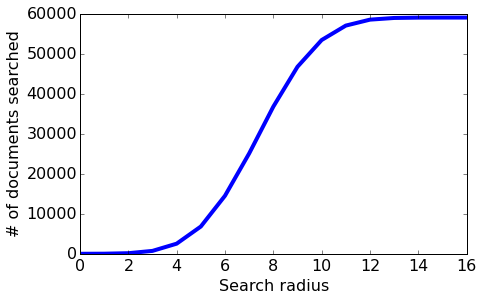

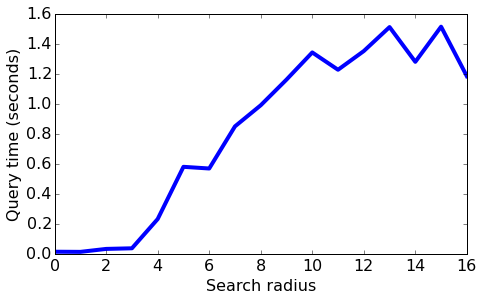

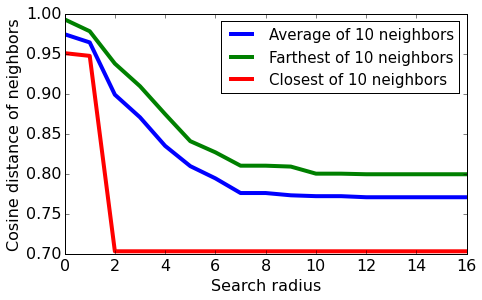

In [148]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

###Quality metrics for neighbors

In [155]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort('distance')[:k]

In [156]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance  = {i:[] for i in xrange(max_radius)}
query_time  = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in xrange(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


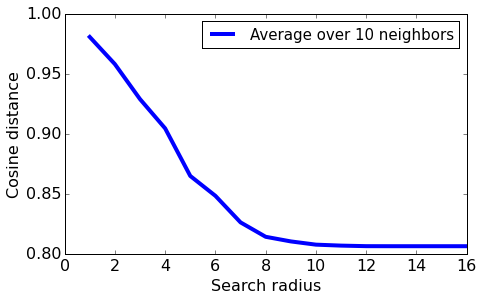

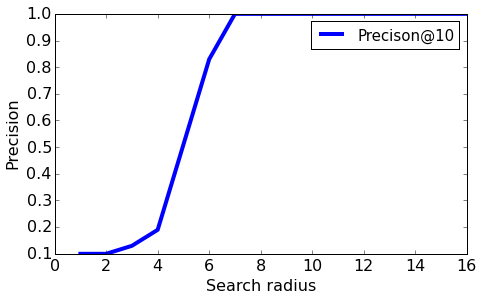

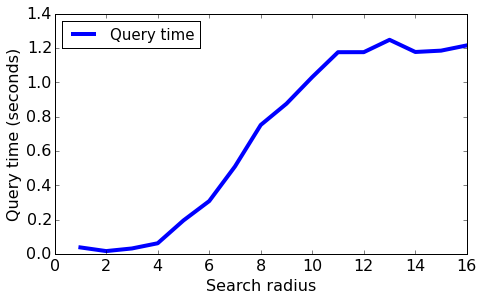

In [157]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

###Effect of number of random vectors

In [158]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


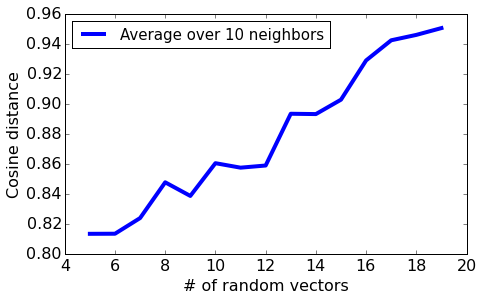

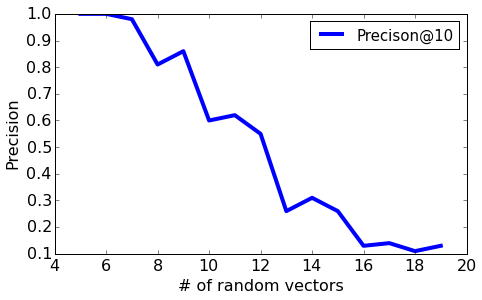

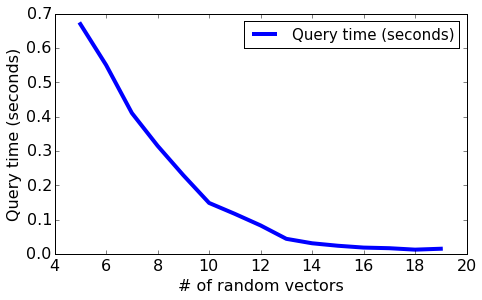

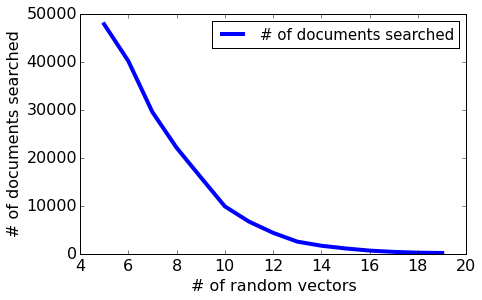

In [159]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()